[View in Colaboratory](https://colab.research.google.com/github/rdenadai/Image-Study-Notebooks/blob/master/notebooks/madelbrot.ipynb)

## Mandelbrot


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

np.warnings.filterwarnings('ignore')

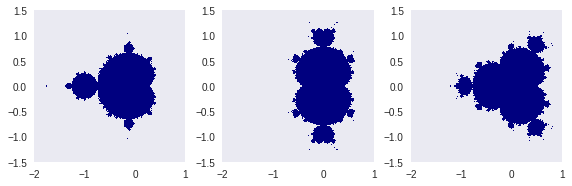

In [56]:
N = 500
x, y = np.linspace(-2, 1, N), np.linspace(-1.5, 1.5, N)
c = x[:, np.newaxis] + (y[np.newaxis, :] * 1j)
z = c

mandelbrot = []
for i in [2, 3, 4]:
    for _ in range(100):
        z = z**i + c
    mandelbrot.append(np.abs(z))
    z = c

plt.figure(figsize=(8, 8))
for i, mandel in enumerate(mandelbrot):
    plt.subplot(3, 3, i+1)
    plt.imshow(mandel.T, extent=[-2, 1, -1.5, 1.5], cmap='jet')
    plt.grid(False)
plt.tight_layout()
plt.show()

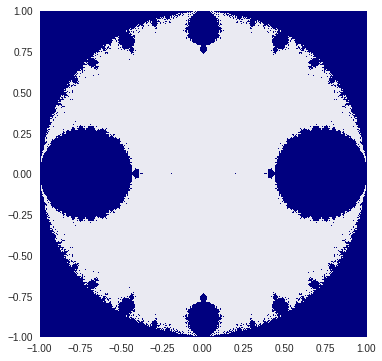

In [43]:
N = 500
x, y = np.linspace(-1, 1, N), np.linspace(-1, 1, N)
c = x[:, np.newaxis] + (y[np.newaxis, :] * 1j)
z = c
for _ in range(100):
    z = np.sin(z/c)
mandelbrot = np.abs(z)

plt.figure(figsize=(6, 6))
plt.imshow(mandelbrot.T, extent=[-1, 1, -1, 1], cmap='jet')
plt.grid(False)
plt.show()